In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import importlib
warnings.filterwarnings('ignore')

In [39]:
sd = "2018-01-01"
ed = "2024-01-01"


snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data_tab = pd.read_html(snp500url)

tickers = data_tab[0][1:]['Symbol'].tolist()


raw = yf.download(tickers=tickers, start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['GEV', 'SW', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [40]:
dataset = pd.DataFrame(raw)
missing_frac = dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.2].index))
dataset.drop(columns=drop_list, axis = 1, inplace=True)
dataset.bfill(axis='index', inplace=True)
print('\nNull values:', dataset.isnull().values.any())
print('NaN values:', dataset.isna().values.any())


Null values: False
NaN values: False


In [85]:
from sklearn.preprocessing import StandardScaler
returns = dataset.pct_change().dropna()
returns = pd.DataFrame(returns).reset_index().drop(columns="Date")
scaler = StandardScaler()
normalized_returns = pd.DataFrame(scaler.fit_transform(returns), columns=returns.columns, index=returns.index)

R = normalized_returns.corr().reset_index()

In [67]:
import yfinance as yf
import pandas as pd
import networkx as nx
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px


G = nx.Graph()
G.add_nodes_from(dataset.columns)
threshold = 0.5
for i in range(len(dataset.columns)):
    for j in range(i + 1, len(dataset.columns)):
        corr = R.iloc[i, j]
        if abs(corr) > threshold:
            G.add_edge(dataset.columns[i], dataset.columns[j], weight=corr)

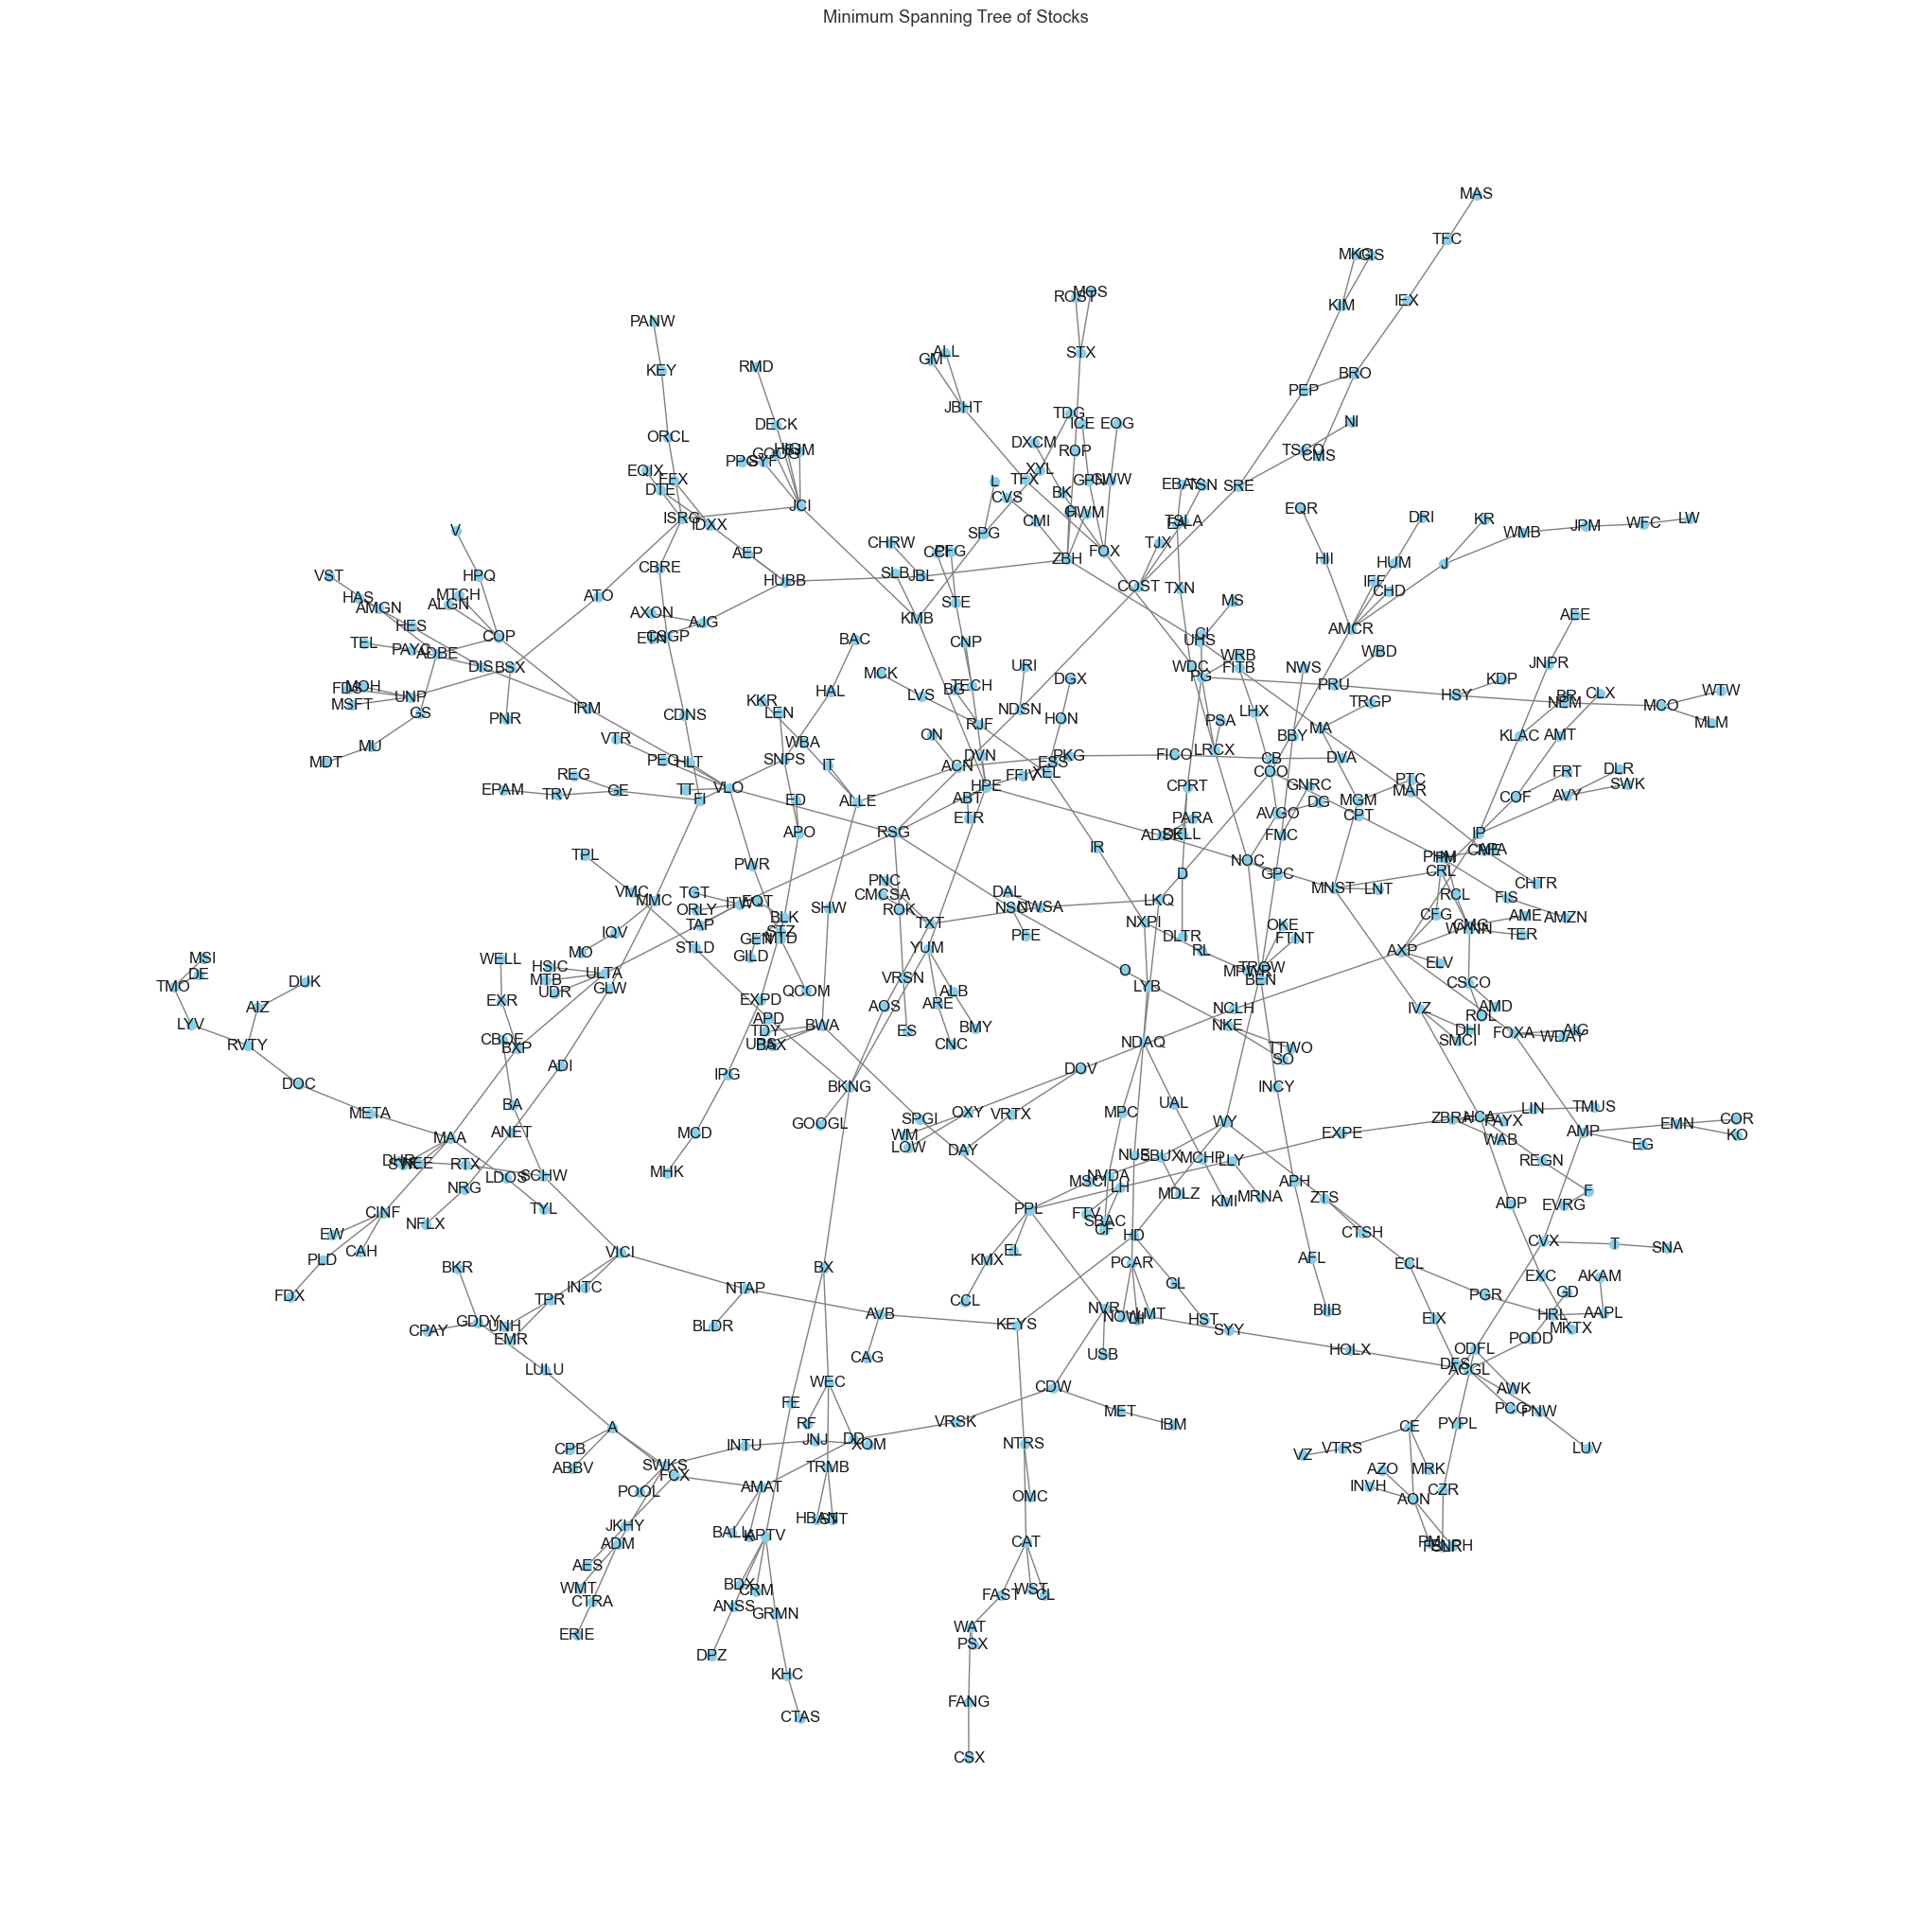

In [70]:
mst = nx.minimum_spanning_tree(G)

# Plot MST
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(mst)
nx.draw(mst, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
plt.title("Minimum Spanning Tree of Stocks")
plt.show()

In [71]:
benchmark_data = yf.download("SPY", start=sd, end=ed, auto_adjust=True)['Close']
benchmark_returns = benchmark_data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [72]:
results = pd.DataFrame(columns=['Method', 'Max_d', 'Silhouette Score', 'Cophenetic Correlation', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])

# Clustering evaluation
methods = ['single', 'complete', 'average', 'centroid', 'ward', 'median']
max_d_values = [0.5, 0.6, 0.7, 0.8, 0.9]

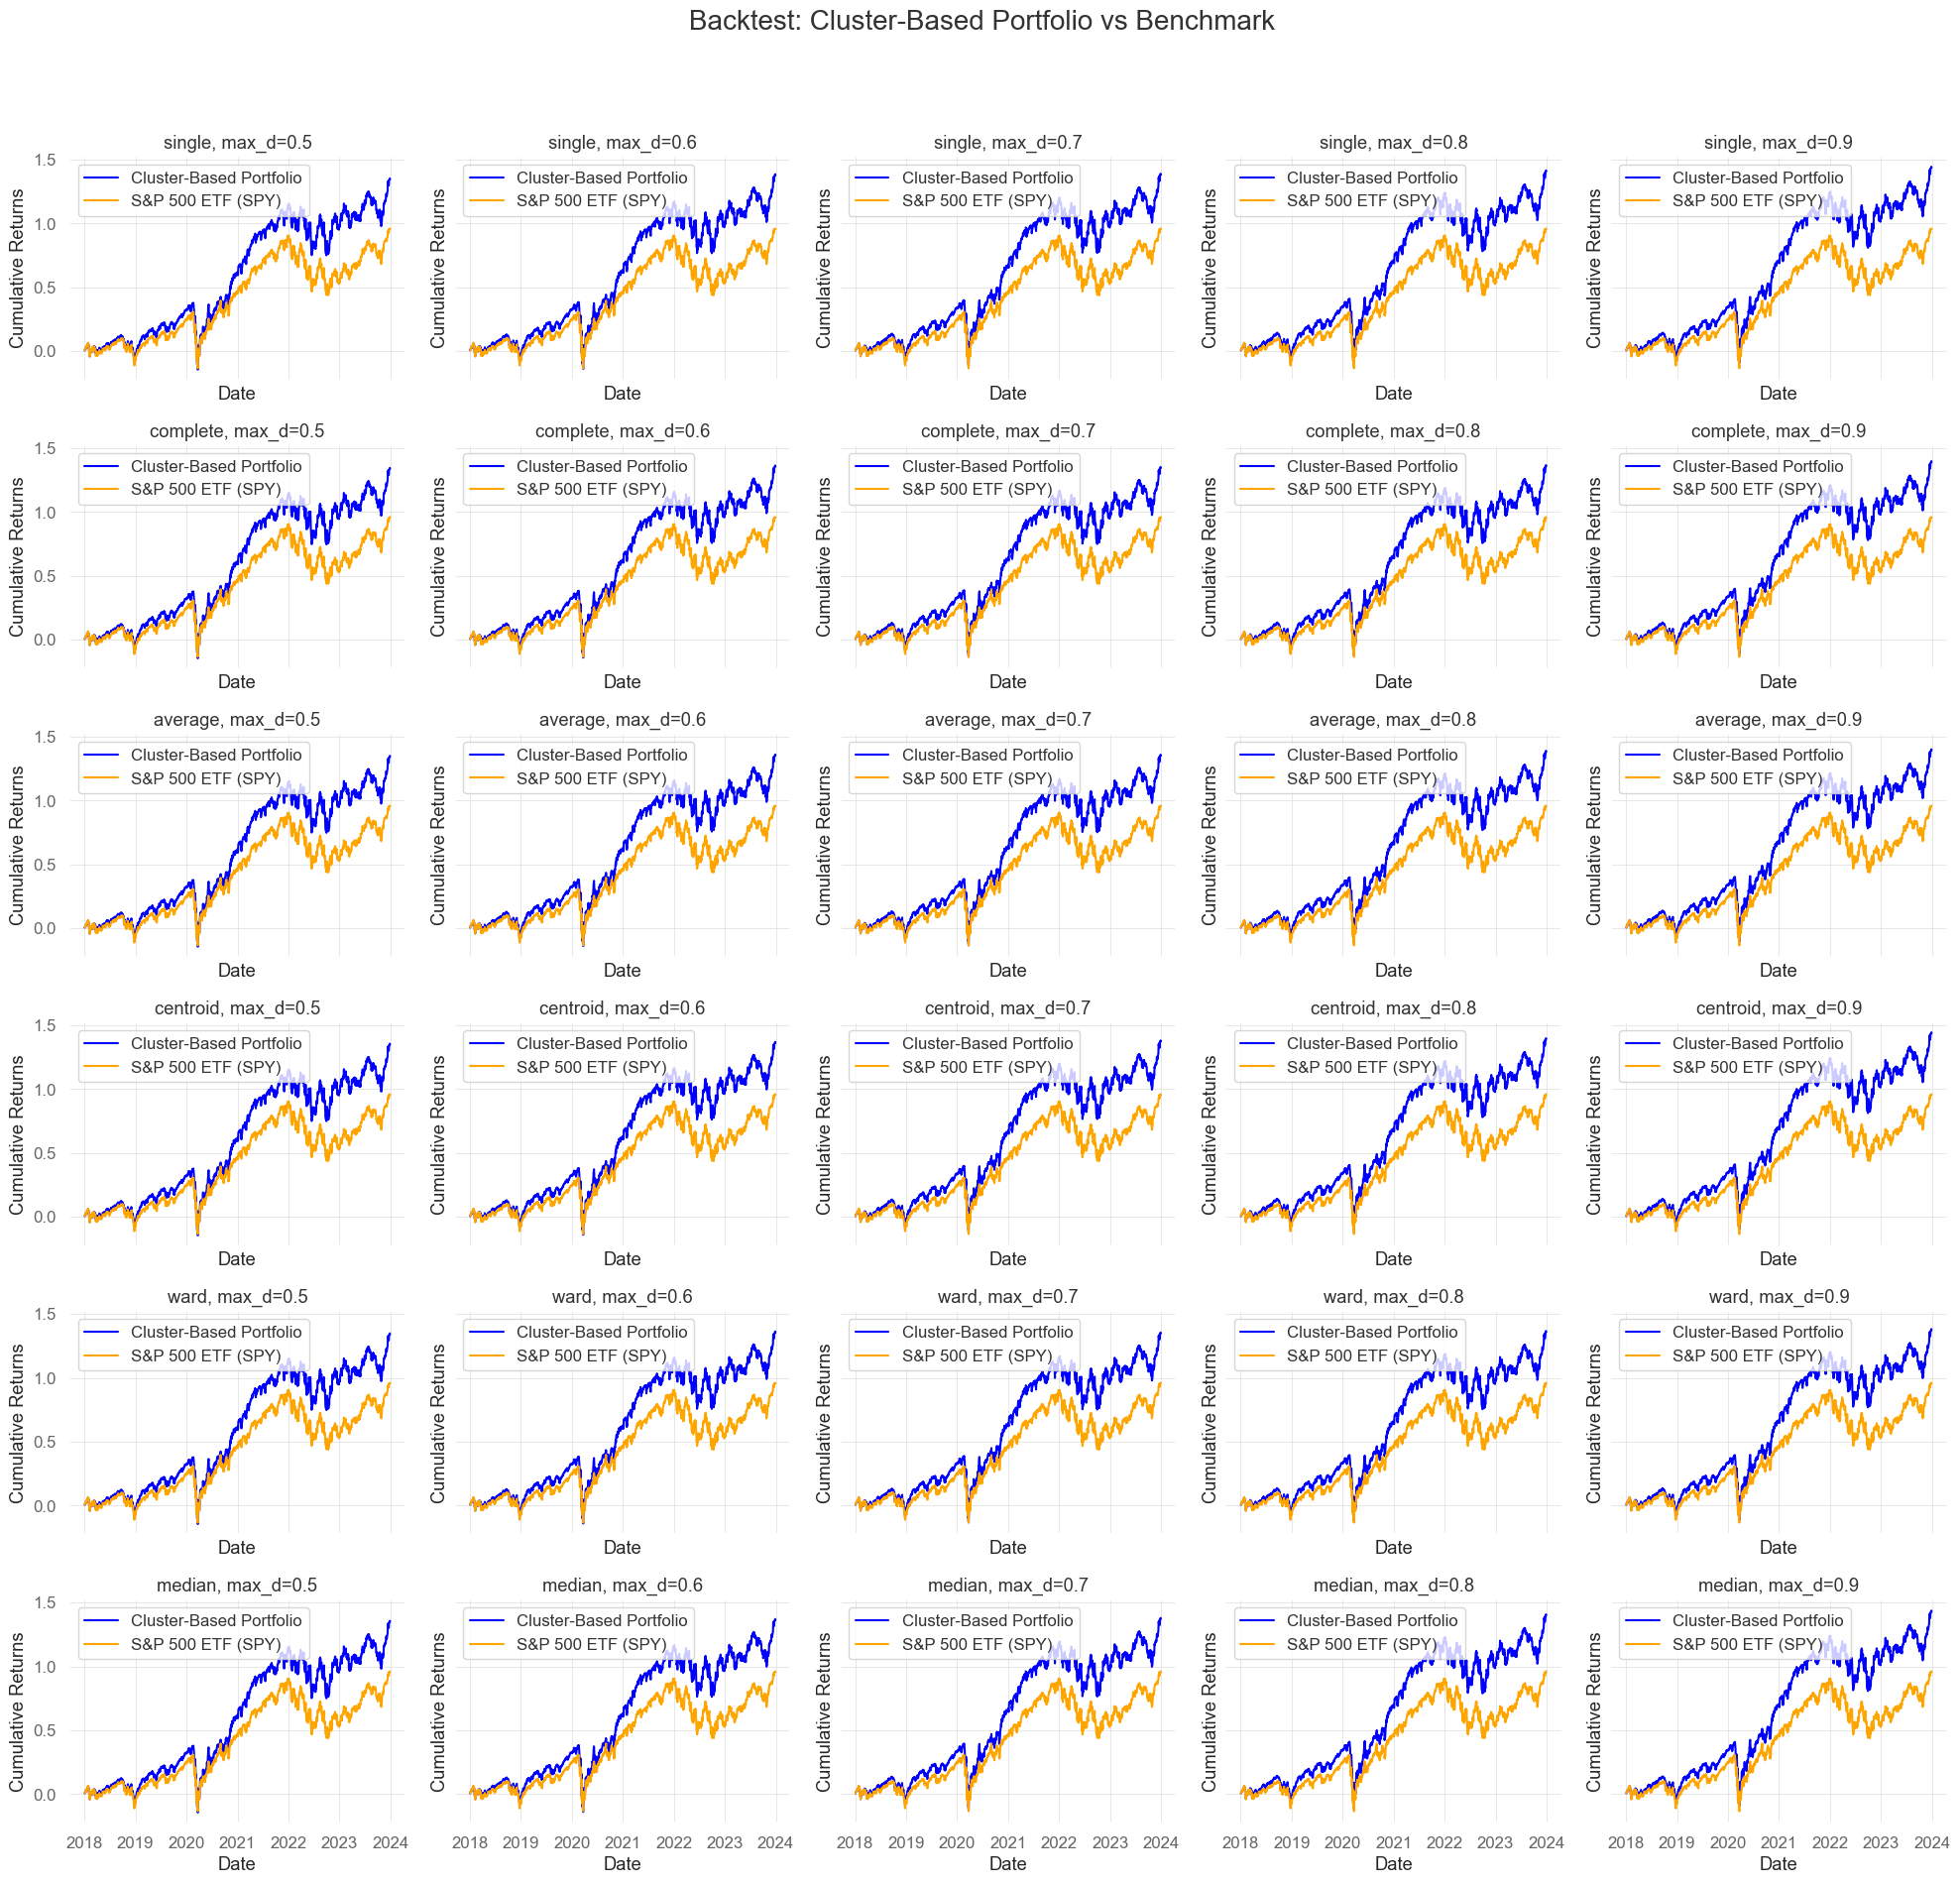

In [88]:
# Prepare subplots
fig, axes = plt.subplots(len(methods), len(max_d_values), figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle("Backtest: Cluster-Based Portfolio vs Benchmark", fontsize=20)

for i, method in enumerate(methods):
    for j, max_d in enumerate(max_d_values):
        distance_matrix = 1 - (R.drop(columns = "Ticker")).abs()
        condensed_distance_matrix = pdist(distance_matrix)
        linkage_matrix = linkage(condensed_distance_matrix, method=method)
        clusters = fcluster(linkage_matrix, max_d, criterion='distance')

        # Calculate metrics
        silhouette_avg = silhouette_score(distance_matrix, clusters, metric='precomputed')
        c, _ = cophenet(linkage_matrix, condensed_distance_matrix)
        ch_score = calinski_harabasz_score(normalized_returns.T, clusters)
        db_score = davies_bouldin_score(normalized_returns.T, clusters)

        # Append to results
        result = pd.DataFrame({
            'Method': [method],
            'Max_d': [max_d],
            'Silhouette Score': [silhouette_avg],
            'Cophenetic Correlation': [c],
            'Calinski-Harabasz Score': [ch_score],
            'Davies-Bouldin Score': [db_score]
        })
        results = pd.concat([results, result], ignore_index=True)

        # Cluster-based portfolio
        cluster_returns = []
        unique_clusters = np.unique(clusters)
        for cluster in unique_clusters:
            cluster_stocks = [dataset.columns[k] for k in range(len(dataset.columns)) if clusters[k] == cluster]
            cluster_data = returns[cluster_stocks].mean(axis=1)
            cluster_returns.append(cluster_data)

        # Combine cluster returns into a portfolio
        combined_returns = pd.concat(cluster_returns, axis=1).mean(axis=1)
        combined_cum_returns = (1 + combined_returns).cumprod() - 1
        
        benchmark_cum_returns = (1 + benchmark_returns).cumprod() - 1
        # Plot on the respective subplot
        ax = axes[i, j]
        ax.plot(benchmark_cum_returns.reset_index()["Date"], combined_cum_returns, label="Cluster-Based Portfolio", color="blue")
        ax.plot(benchmark_cum_returns.reset_index()["Date"], benchmark_cum_returns.reset_index()["SPY"], label="S&P 500 ETF (SPY)", color="orange")
        ax.set_title(f"{method}, max_d={max_d}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Cumulative Returns")
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [89]:
results

,Method,Max_d,Silhouette Score,Cophenetic Correlation,Calinski-Harabasz Score,Davies-Bouldin Score
0,single,0.5,0.042243,0.559915,6.279379,0.362404
1,single,0.6,0.055037,0.559915,4.953900,0.450658
2,single,0.7,0.057578,0.559915,4.026206,0.561607
3,single,0.8,0.070551,0.559915,3.528010,0.666397
4,single,0.9,0.086497,0.559915,3.371769,0.806512
...,...,...,...,...,...,...
124,median,0.5,0.038035,0.392541,6.149003,0.369651
125,median,0.6,0.052876,0.392541,5.225936,0.456835
126,median,0.7,0.066184,0.392541,4.298657,0.542274
127,median,0.8,0.064346,0.392541,3.640019,0.799737
